# Exercise 8.2
Large arrays of radio antennas can be used to measure cosmic rays by recording the electromagnetic radiation generated in the atmosphere.
These radio signals are strongly contaminated by galactic noise as well as signals from human origin. Since these signals appear to be similar to the background, the discovery of cosmic-ray events can be challenging.
## Identification of signals
In this exercise, we design an RNN to classify if the recorded radio signals contain a cosmic-ray event or only noise.

The signal-to-noise ratio (SNR) of a measured trace $S(t)$ is defined as follows:

$$\mathrm{SNR}=\frac{S^{\mathrm{signal}}(t)_\mathrm{max}}{\mathrm{RMS}[S(t)]},$$  
where $S^{\mathrm{signal}}(t)_\mathrm{max}$ denotes the maximum amplitude of the (true) signal.

Typical cosmic-ray observatories enable a precise reconstruction at an SNR of roughly 3.

We choose a challenging setup in this task and try to identify cosmic-ray events in signal traces with an SNR of 2.  
Training RNNs can be computationally demanding, thus, using a GPU for this task is required.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

layers = keras.layers
print("keras", keras.__version__)

keras 2.9.0


### Load and prepare dataset
In this task, we use a simulation of cosmic-ray-induced air showers that are measured by radion antennas.  
For more information, see https://arxiv.org/abs/1901.04079.  
The task is to design an RNN which is able to identify if the measured signal traces (shortened to 500 time steps) contains a signal or not.

In [3]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1R-qfxO1jVh88TC9Gnm9JGMomSRg0Zpkx"
output = 'radio_data.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output) # we have 50000 events in total
n_train = 40000 # let's use 40000 for training and validation, the rest we use for testing. 


x_train, x_test = f["traces"][:n_train], f["traces"][n_train:]  # measured traces (signal + noise), or only noise

signals = f["signals"]  # signal part (only available for cosmic-ray events)
# if the even is noise, the signal trace is consists of zeros. 
# so we can find out if an event is signal or noise by selecting the events
# that have non-zero entries in the signal arrays. 
labels = (signals.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
# split up the labels into training and test data set
y_train, y_test = labels[:n_train], labels[n_train:]

## Plot example signal traces
Left: signal trace containing a cosmic-ray event. The underlying cosmic-ray signal is shown in red, the backgrounds + signal is shown in blue.
Right: background noise.

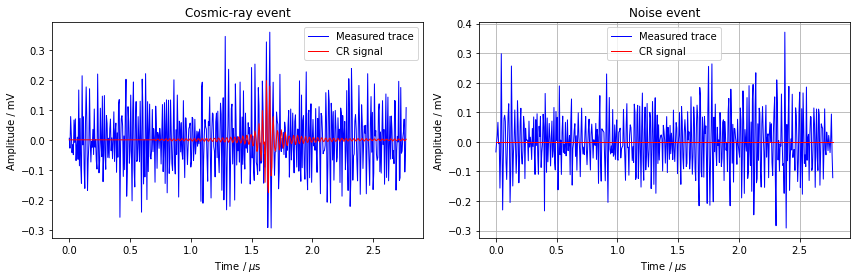

In [4]:
from matplotlib import pyplot as plt
# these two lines calculate the time values for each bin.
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6

i_signal_event = 19
i_noise_event = 21

plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
# first plot a signal event
# f["traces"][labels.astype(bool)] selects all signal traces
plt.plot(t, f["traces"][labels.astype(bool)][i_signal_event], linewidth = 1, color="b", label="Measured trace")
plt.plot(t, signals[labels.astype(bool)][i_signal_event], linewidth = 1, color="r", label="CR signal")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Cosmic-ray event")
plt.subplot(1, 2, 2)

# now plot a noise event
plt.plot(t, f["traces"][~labels.astype(bool)][i_noise_event], linewidth = 1, color="b", label="Measured trace")
plt.plot(t, signals[~labels.astype(bool)][i_signal_event], linewidth = 1, color="r", label="CR signal") # we see that the signal is always zero because we plot a noise event. 
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Noise event")

plt.grid(True)
plt.tight_layout()

## Nornalization

There are many different ways to normnalize the data. Here we simply look at the maximum of the absolute values of the sample and divide all the sample by this maximum.

In [5]:
# Normalize the input data
MAX_train = np.max(np.absolute(x_train))
MAX_test = np.max(np.absolute(x_test))

MAX = np.max(np.array([MAX_train, MAX_test]))

x_train = x_train / MAX
x_test = x_test / MAX

### Define RNN model
In the following, design a cosmic-ray model to identify cosmic-ray events using an RNN-based classifier.

In [6]:
#z0 = layers.Input(shape=[None, 500])


model = keras.models.Sequential()
# because the network architecture includes a dense layer at the end, we need to specify the input shape, i.e., 
# the length of the input array is not arbitrary. 

model.add(tf.keras.Input(shape=(500,1)))
model.add(layers.LSTM(15, return_sequences=True))       #, input_shape=(500,1)) !?
model.add(layers.LSTM(15, return_sequences=True)) 
model.add(layers.LSTM(15, return_sequences=True)) 

# it is a classification task: Noise or Signal. 
# for a binary classification task, we can use a single output node with a 
# sigmoid activation. 
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500, 15)           1020      
                                                                 
 lstm_1 (LSTM)               (None, 500, 15)           1860      
                                                                 
 lstm_2 (LSTM)               (None, 500, 15)           1860      
                                                                 
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dropout (Dropout)           (None, 7500)              0         
                                                                 
 dense (Dense)               (None, 1)                 7501      
                                                                 
Total params: 12,241
Trainable params: 12,241
Non-traina

Here we decided to build a network with 3 layers of 15 nodes each

#### Pre-processing of data and RNN training

The training might take a long time. Either adjust the number of epochs, or just cancel the computation at some point. The `model` object will still contain the latest version of the network. 

In [38]:
model.compile(
    loss='binary_crossentropy',  # for a binary classification task, use `binary_crossentropy`
    optimizer=keras.optimizers.Adam(1e-3, decay=0.00008),
    metrics=['accuracy'])

results = model.fit(x_train[...,np.newaxis], y_train,
                    batch_size=128,
                    epochs=100, 
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                                 keras.callbacks.EarlyStopping(patience=15, verbose=1),
                                 # add more callbacks here (e.g. save the history)
                                 keras.callbacks.ModelCheckpoint("cosmic_ray{}.h5".format(model.name), save_best_only=True, monitor="val_accuracy", save_weights_only=True),
                                 tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
                                 ]
                    )

Epoch 1/100
282/282 [==============================] - 18s 50ms/step - loss: 0.5832 - accuracy: 0.6868 - val_loss: 0.5831 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 2/100
282/282 [==============================] - 14s 49ms/step - loss: 0.5827 - accuracy: 0.6886 - val_loss: 0.5832 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 3/100
282/282 [==============================] - 13s 47ms/step - loss: 0.5799 - accuracy: 0.6909 - val_loss: 0.5802 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 4/100
282/282 [==============================] - 14s 49ms/step - loss: 0.5804 - accuracy: 0.6886 - val_loss: 0.5787 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 5/100
282/282 [==============================] - 13s 46ms/step - loss: 0.5821 - accuracy: 0.6898 - val_loss: 0.5803 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 6/100
282/282 [==============================] - 13s 46ms/step - loss: 0.5786 - accuracy: 0.6916 - val_loss: 0.5805 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 7/100
282/282 [==============================]

In [39]:
# evaluate the model performance on the test data set
test_loss, test_accuracy = model.evaluate(x_test[...,np.newaxis], y_test)

313/313 [==============================] - 7s 21ms/step - loss: 0.5760 - accuracy: 0.6923


### Plot loss and accuracy

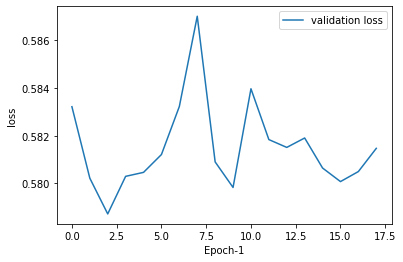

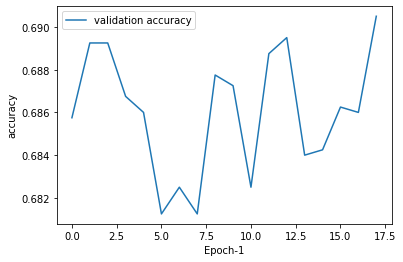

final accuracy on the test data set : 0.692300021648407
final loss on the test data set : 0.5759572386741638


In [40]:
# load best model
model.load_weights(f"cosmic_ray{model.name}.h5")

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)

# add plots below - Plot the training and validation accuracy as a function of epoch
val_loss = history["val_loss"][1:]
val_accuracy = history["val_accuracy"][1:]

plt.plot(val_loss,label="validation loss")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("loss")
plt.show()

plt.plot(val_accuracy,label="validation accuracy")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

# final accuracy and loss on the test data set
print("final accuracy on the test data set :", test_accuracy)
print("final loss on the test data set :", test_loss)

## Comments

The results of this network aren't great at all including the early stopping due to lack of convergence, this can be due to the structure itself (not large and deep enough), but also to the inapropriate normalization of the data !